In [1]:
import matplotlib.pyplot as plt
import numpy as np
from commpy.modulation import QAMModem

# Modulos do OptiCommpy
from pyfiles.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from pyfiles.models import phaseNoise, KramersKronigRx, linFiberCh
from pyfiles.tx import simpleWDMTx
from pyfiles.core import parameters
from pyfiles.equalization import edc, mimoAdaptEqualizer
from pyfiles.carrierRecovery import cpr
from pyfiles.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from pyfiles.plot import pconst

import scipy.constants as const
# Modulo responsável pelo pre-processamento, criação de datasets, treinamento e criação de modelos. 
from pyfiles.functions import ANN_model

### Simulação de uma transmissão de sinal óptico de polarização única

In [2]:
## Parâmetros do Transmissor:

paramTx = parameters()
paramTx.M = 16                 # ordem do formato de modulação
paramTx.Rs = 32e9              # taxa de símbolo [baud]
paramTx.SpS = 4                # amostras por símbolo
paramTx.Nbits = 400000         # número total de bits por polarização
paramTx.pulse = "rrc"          # filtro de modelagem de pulso
paramTx.Ntaps = 1024           # número de coeficientes de filtro de modelagem de pulso
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # potência do sinal óptico [dBm]
paramTx.Nch = 1                # número de canais WDM
paramTx.Fc = 193.1e12          # frequência central do espectro óptico
paramTx.freqSpac = 37.5e9      # espaçamento da grade WDM

## Parâmetros do canal óptico:

Ltotal = 55      # distância total do link [km]
alpha = 0        # parâmetro de perda da fibra [dB/km]
D = 16           # parâmetro de disperção [ps/nm/km]
Fc = paramTx.Fc  # frequência óptica central do espectro WDM [Hz]

## Parâmetros do receptor:

# local oscillator (LO) - Alterar a frequência do sinal.
FO = paramTx.Rs/2   # deslocamento de frequência
lw = 0*200e3        # espessura da linha
ϕ_lo = 0            # fase inicial em rad
Plo_dBm = 12        # potência em dBm

# Taxa de amostragem ADC
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 2

## Parâmetros gerais de simulação:

chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

### Script de simulação do núcleo

In [29]:
# gera o sinal óptico
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simula a propagação de sinal linear na fibra
sigCh_0 = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)
# adiciona multiplas disperções
sigCh_1 = linFiberCh(sigTx, 25, alpha, D, Fc, Fs)
sigCh_2 = linFiberCh(sigTx, 35, alpha, D, Fc, Fs)
sigCh_3 = linFiberCh(sigTx, 55, alpha, D, Fc, Fs)

# plota o espectro óptico antes e depois da transmissão

# Antes
""" plt.figure()
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
) """

# Depois
""" plt.psd(
    sigCh,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend(loc="lower left")
plt.title("optical spectrum")
"""
# detecção e demodulação do receptor

Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# gera o campo LO para todas as disperções
π = np.pi

""" for index in range(0, 4):
    signalCh = globals().get('sigCh_%d' % index)
    
    t = np.arange(0, len(signalCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(signalCh), Ts)
    
    # Cria o campo LO
    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Adiciona LO ao sinal recebido
    sigRx = np.sqrt(Plo) + signalCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    
    sfm = sigRx.copy()
    sfm_total = np.concatenate((sfm, sigRx.copy()))

    print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(signalCh))))

    # Reamostragem para taxa de amostragem ADC
    signalCh = resample(signalCh, paramADC)
    signalCh_total = np.concatenate((signalCh, signalCh)) 
"""
# Gera o campo LO para sigCh_0
t = np.arange(0, len(sigCh_0))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_0), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Adiciona o campo LO para o sinal recebido
sigRx = np.sqrt(Plo) + sigCh_0 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_0 = sigRx.copy()

# Gera o campo LO para sigCh_1
t = np.arange(0, len(sigCh_1))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_1), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Adiciona o campo LO para o sinal recebido
sigRx = np.sqrt(Plo) + sigCh_1 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_1 = sigRx.copy()

# Gera o campo LO para sigCh_2
t = np.arange(0, len(sigCh_2))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_2), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Adiciona o campo LO para o sinal recebido
sigRx = np.sqrt(Plo) + sigCh_2 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_2 = sigRx.copy()

# Gera o campo LO para sigCh_3
t = np.arange(0, len(sigCh_3))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_3), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Adiciona o campo LO para o sinal recebido
sigRx = np.sqrt(Plo) + sigCh_3 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_3 = sigRx.copy()

# plota o espectro após adicionar LO
""" plt.psd(
    sigRx,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum"); """

# Reamostragem para taxa de amostragem ADC
sigCh_0 = resample(sigCh_0, paramADC)
sigCh_1 = resample(sigCh_1, paramADC)
sigCh_2 = resample(sigCh_2, paramADC)
sigCh_3 = resample(sigCh_3, paramADC)
sigCht = np.concatenate((sigCh_0, sigCh_1, sigCh_2, sigCh_3))

sfm_0 = resample(sfm_0, paramADC)
sfm_1 = resample(sfm_1, paramADC)
sfm_2 = resample(sfm_2, paramADC)
sfm_3 = resample(sfm_3, paramADC)
sfmt = np.concatenate((sfm_0, sfm_1, sfm_2, sfm_3))

newFs = paramADC.SpS_out*paramTx.Rs

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM dignal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz


### Simulação do receptor óptico de detecção direta ideal

In [30]:
# Número de amostras de amplitude para NN
N = 256

# Captura a intensidade do sinal transmitido em todas as disperções
Amp = np.abs(sfmt)
Amp = resample(Amp, paramADC)
sfmt = sfm/np.sqrt(signal_power(sfm))

# Obtem amostras de amplitude e fase do sinal

# Amostras de fase
sigPhase = np.angle(sfmt)
# Amostras de amplitude
sigAmp = np.pad(np.abs(sfmt), (int(N/2), int(N/2)), 'constant')

### Estágio de recuperação de fase

In [31]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

Epoch 1/100
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0133 - val_loss: 0.0019
Epoch 2/100
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 1s 1ms/step - loss: 9.8946e-04 - val_loss: 9.5588e-04
Epoch 4/100
1094/1094 [==============================] - 1s 1ms/step - loss: 7.8458e-04 - val_loss: 9.6715e-04
Epoch 5/100
1094/1094 [==============================] - 1s 1ms/step - loss: 7.3359e-04 - val_loss: 9.0298e-04
Epoch 6/100
1094/1094 [==============================] - 1s 1ms/step - loss: 7.1062e-04 - val_loss: 8.9375e-04
Epoch 7/100
1094/1094 [==============================] - 1s 1ms/step - loss: 6.9684e-04 - val_loss: 6.8073e-04
Epoch 8/100
1094/1094 [==============================] - 1s 1ms/step - loss: 6.6599e-04 - val_loss: 7.0538e-04
Epoch 9/100
1094/1094 [==============================] - 1s 1ms/step - loss: 6.4770e-04 - val_loss: 6.0074e-04
Epoch 10/100
1094

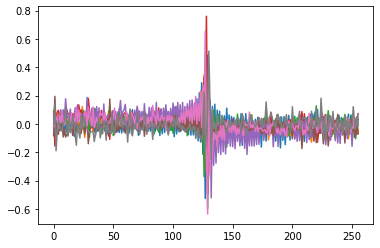

In [32]:
# Cria o dataset para o treinamento
x_train = np.zeros((len(sigPhase), N))

for index in range(len(sigPhase)):
    x_train[index] = sigAmp[index:N+index]

# Conjunto de rótulos de fase
y_train = sigPhase.copy()

# define neural network model
stop = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(8, input_shape=(N,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8,activation='gelu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)

model.summary()

cw1 = model.layers[1].get_weights()
plt.plot(cw1[0])


In [33]:
phiTime_NN = model.predict(x_train)
phiTime_NN = phiTime_NN.reshape(-1,)

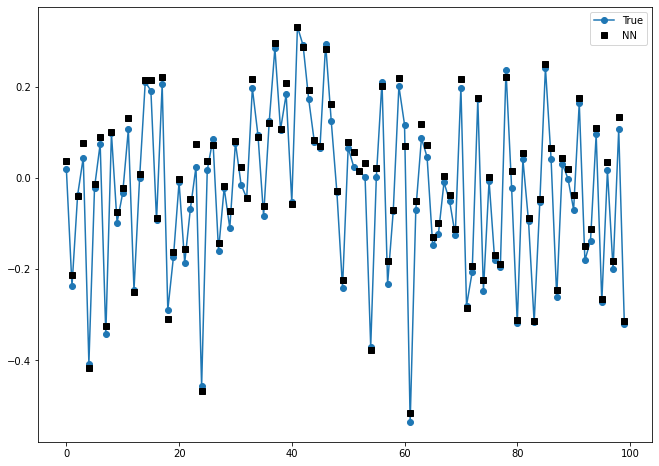

In [34]:
plt.figure(figsize=(11, 8))
plt.plot(np.angle(sfmt)[300:400], '-o', label='True')
plt.plot(phiTime_NN[300:400], 's', label='NN', color='black')
plt.legend()